# Tutorial/Walkthrough of the multi_plot class and what you can do with it

The purpose of this class is ultimately create an image that can capture the details and information about the absorption features of a specific ion. This code creates this image in a handful of steps but this if the final product. (This image was made using FOGGIE data http://foggie.science/)
![Multi_plot Example](sample_mp.png)

We'll go into more detail about the specifics of each part. But the main idea is that the slice plot, the number density plot and the line of sight velocity plot contain a lot of information about the physics of the absorber. Sadly, observers don't have access to any of that are instead left with just the absorption spectra (the last plot).

To better understand the Circumgalactic medium surrounding galaxies, we need to know how the spectra we see relates to the real physical properties of the gas. There are many degeneracies that can make studying the spectra incredibly annoying but this tool should hopefully help bring a better understanding to these studies.

## Getting Started

We first need a dataset containing a galaxy and a light ray going through the galaxy. Here we will download a simple test dataset from enzo to use since it is relatively quick to use and small enough that everything should run quite quickly. We will also quickly use trident to make a light ray so we can go through the different tools in the `multi_plot` class.

If you want to use a "better" dataset, all you'll need to do is change `ds_fname` as well as provide or construct your own light ray

In [4]:
# this is a sample enzo dataset from yt
# it might take a little bit to download
!wget http://yt-project.org/data/IsolatedGalaxy.tar.gz
print ("Got IsolatedGalaxy")
!tar xzf IsolatedGalaxy.tar.gz

Got IsolatedGalaxy


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import yt
import trident
from sys import path
path.insert(0, "../multi_plot_movie/")
import multi_plot

First define parameters and file paths to dataset as well as ray

In [56]:
#load ds and create ray to look at
ds = yt.load(ds_fname)
ray =trident.make_simple_ray(ds, [0.4, 0.5, 0.55], 
                             [0.6, 0.5, 0.55], lines=['H I', 'C IV','O VI'])

yt : [INFO     ] 2019-08-09 16:54:59,085 Parameters: current_time              = 0.0060000200028298
yt : [INFO     ] 2019-08-09 16:54:59,086 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2019-08-09 16:54:59,087 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2019-08-09 16:54:59,088 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2019-08-09 16:54:59,090 Parameters: cosmological_simulation   = 0.0
Parsing Hierarchy : 100%|██████████| 173/173 [00:00<00:00, 10424.45it/s]
yt : [INFO     ] 2019-08-09 16:54:59,129 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2019-08-09 16:55:00,226 Getting segment at z = 0.0: [0.4  0.5  0.55] unitary to [0.6  0.5  0.55] unitary.
yt : [INFO     ] 2019-08-09 16:55:00,228 Getting subsegment: [0.4 unitary, 0.5 unitary, 0.55 unitary] to [0.6 unitary, 0.5 unitary, 0.55 unitary].
yt : [INFO     ] 2019-08-09 16:55:00,369 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2019-08

In [57]:
ds_fname = "IsolatedGalaxy/galaxy0030/galaxy0030"
ray_fname= "ray.h5"

# Isolated galaxy is oriented nicely but this isn't always the case 
# with other dataset (especially cosmological ones)
center=[0.5, 0.5, 0.5]
norm_vec=[0, 0, 1]
redshift=0

Call the `multi_plot` class with the defined parameters

In [58]:
mp = multi_plot.multi_plot(ds_fname, ray_fname, 
                ion_name='H I',        # ion to look at
                north_vector=norm_vec, # vector poiting along galaxy's axis of rotaion
                center_gal=center,     # coordinates of galaxy's center
                wavelength_width=20,   # width of spectra plot in wavelength space
                redshift=redshift,     # redshift of simulation
                use_spectacle=True,    # whether to fit spectra with spectacle
                plot_spectacle=False)   # whether to plot spectacle fits on spectra

yt : [INFO     ] 2019-08-09 16:55:04,586 Parameters: current_time              = 0.0060000200028298
yt : [INFO     ] 2019-08-09 16:55:04,587 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2019-08-09 16:55:04,588 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2019-08-09 16:55:04,589 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2019-08-09 16:55:04,590 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-08-09 16:55:04,712 Parameters: current_time              = 0.0060000200028298 code_time
yt : [INFO     ] 2019-08-09 16:55:04,712 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2019-08-09 16:55:04,713 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2019-08-09 16:55:04,714 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2019-08-09 16:55:04,715 Parameters: cosmological_simulation   = 0.0


<Figure size 720x720 with 0 Axes>

# Computing column densities 
Currently there are three methods used by the `multi_plot` class:

* Contour method `mp.contour`
* Fitting method `mp.use_spectacle`
* Full Sum method

The Contour method uses code constructed by Hillary Egan and can be found on bitbucket or maybe I'll add it to this Repo. The method works by using an initial cutoff (which is roughly the mean background density for the given ion) to define regions in numberdensity where there is at least one absorber. Then for a given region, it finds the maximum number density and sets the cutoff to be a fraction of that (currently 0.5). Then intervals are defined as continuous regions where the number density is above this new cutoff. Then intervals are discared if their column density is too small (default is LogN>12.0 see `spectacle_defaults` for altering this).  

The Fitting method extracts absorbers by trying to fit the absorption spectra created by trident machinery. The fitting is done by using the spectacle libray and the type of features it attempts to fit to the spectra can be altered by setting the `spectacle_defaults`. Some defaults parameters are automatically set when initializing the class. 

The last method is the simplest method. It simply sums the total column density of the light ray and returns that value. It doesn't attempt to extract any individual features or any other paramet

Quick note: These methods don't always agree and have their deficiencies but that is especially true if you are using the provided dataset since it is... not the most refined :)

### How to get Absorption information

If all you want is the column densities then you can use `mp.compute_col_density` and take the first object returned which will have a list of column densities computed using the contour method, fitting method, and then the full sum.

In [59]:
col_densities, txt, lines, n_fitted = mp.compute_col_density() 
contour_cd, fitted_cd, full_sum_cd = col_densities

#print out values
print("Total Column Density (LogN with N in cm^-2)")
print(f"Contour method: {contour_cd:.2f}")
print(f"Fitted method: {fitted_cd:.2f}")
print(f"Full Sum method: {full_sum_cd:.2f}")

yt : [INFO     ] 2019-08-09 16:55:05,645 Returning an all_data data container.
yt : [INFO     ] 2019-08-09 16:55:05,717 Allocating for 1.340e+02 particles (index particle type 'all')
yt : [INFO     ] 2019-08-09 16:55:05,722 Identified 1.130e+02 octs
yt : [INFO     ] 2019-08-09 16:55:05,952 Returning an all_data data container.
yt : [INFO     ] 2019-08-09 16:55:05,960 Setting instrument to Custom
yt : [INFO     ] 2019-08-09 16:55:05,966 Creating spectrum
yt : [INFO     ] 2019-08-09 16:55:06,002 134 out of 134 line components will be deposited as unresolved lines.
Adding line - H I 1216 [1215.670100 A]: : 100%|██████████| 134/134 [00:00<00:00, 1566.24it/s]
yt : [INFO     ] 2019-08-09 16:55:06,094 Not adding continuum Ly C: insufficient column density or out of range
spectacle [INFO    ]: Estimated initial values:
    Ion: HI1216
    Centroid: -49.3254 km / s (1215.67 Angstrom)
    Column density: 13.9628, (9.17826e+13 1 / cm2)
    Doppler width: 89.5278 km / s
spectacle [WARNING ]: Astro

Total Column Density (LogN with N in cm^-2)
Contour method: 15.33
Fitted method: 16.54
Full Sum method: 15.82


the `multi_plot` class can give more than just the total column densities. For the first two methods, each absorption feature can be returned using `mp.compute_col_density` and `mp.get_contour_intervals`

Once you have the intervals from `mp.get_contour_intervals` you can use them to access any of the fields in the ray (which can be accessed through `mp.ray`). In this example we get the velocity of the absorption feature as well as it's column density

In [60]:
#for the contour method
intervals, cont_lcd = mp.get_contour_intervals()

print(f"The contour method found {len(cont_lcd)} features:")
for inter, lcd in zip(intervals, cont_lcd):
    #get the beginning and ending index of the interval
    b, e = inter
    
    #find average velocity of feature (along ray)
    velocity_los = mp.ray.all_data()['velocity_los'].in_units('km/s')
    avg_vel = np.mean( velocity_los[b:e] )
    
    print(f"LogN={lcd:.2f} with a velocity of {avg_vel:.0f} km/s")
    

The contour method found 3 features:
LogN=15.10 with a velocity of -27 km/s km/s
LogN=14.81 with a velocity of -22 km/s km/s
LogN=14.39 with a velocity of 4 km/s km/s


`mp.compute_col_density()` outputs the spectacle's Spectral1D class for the largest absorbers found using the fitting method (it is the third output). This holds all the information about the 

In [61]:
#for the fitting method
col_densities, txt, largest_lines, n_fitted = mp.compute_col_density() 

#the txt is meant to be written to a text box when creating the full multi-plot

#largest lines hold spectacle models for the largest absorbers (max of 3)
print(f"The Fitting method found {n_fitted} lines/features")

for line_mod in largest_lines:
    lcd = line_mod.lines[0].column_density.value
    delta_vel = line_mod.lines[0].delta_v.value
    print(f"LogN={lcd:.2f} with a velocity of {delta_vel:.0f} km/s")

yt : [INFO     ] 2019-08-09 16:55:07,093 Returning an all_data data container.
yt : [INFO     ] 2019-08-09 16:55:07,105 Returning an all_data data container.
yt : [INFO     ] 2019-08-09 16:55:07,113 Setting instrument to Custom
yt : [INFO     ] 2019-08-09 16:55:07,121 Creating spectrum
yt : [INFO     ] 2019-08-09 16:55:07,165 134 out of 134 line components will be deposited as unresolved lines.
Adding line - H I 1216 [1215.670100 A]: : 100%|██████████| 134/134 [00:00<00:00, 1480.03it/s]
yt : [INFO     ] 2019-08-09 16:55:07,261 Not adding continuum Ly C: insufficient column density or out of range
spectacle [INFO    ]: Estimated initial values:
    Ion: HI1216
    Centroid: -49.3254 km / s (1215.67 Angstrom)
    Column density: 13.9628, (9.17826e+13 1 / cm2)
    Doppler width: 89.5278 km / s


The Fitting method found 1 lines/features
LogN=16.54 with a velocity of -12 km/s


## Creating a slice

multi plot will automatically create a slice of ion's number density with the right orientation based on the given `north_vector` and the given ray. Creating the slice can take a couple minutes if the simulation is large or has very high resolution.

The slice is created such that it is in the plane of the ray and so that the "up"/Z direction is pointing in the same direction as the galaxy's axis of rotation (perpendicular to the disk).

The ray is annotated on the slice so you can see what physical features are being hit by the ray. Markers are also plotted if `mp.markers` is set to True (defaulted to true when class is initialized). These markers are there to make it easy to look from the slice to the number density and line of site velocity plots

Parsing Hierarchy : 100%|██████████| 173/173 [00:00<00:00, 7595.67it/s]
yt : [INFO     ] 2019-08-09 16:55:08,099 Gathering a field list (this may take a moment.)
yt : [WARNING  ] 2019-08-09 16:55:09,233 Field ('gas', 'H_p0_number_density') already exists. Not clobbering.
yt : [WARNING  ] 2019-08-09 16:55:09,234 Field ('gas', 'H_number_density') already exists. Not clobbering.
yt : [WARNING  ] 2019-08-09 16:55:09,234 Field ('gas', 'H_p0_density') already exists. Not clobbering.
yt : [WARNING  ] 2019-08-09 16:55:09,235 Field ('gas', 'H_density') already exists. Not clobbering.
yt : [WARNING  ] 2019-08-09 16:55:09,235 Field ('gas', 'H_p0_mass') already exists. Not clobbering.
yt : [WARNING  ] 2019-08-09 16:55:09,236 Field ('gas', 'H_mass') already exists. Not clobbering.
yt : [INFO     ] 2019-08-09 16:55:09,450 xlim = -0.100000 0.100000
yt : [INFO     ] 2019-08-09 16:55:09,451 ylim = -0.100000 0.100000
yt : [INFO     ] 2019-08-09 16:55:09,452 Making a fixed resolution buffer of (('gas', '


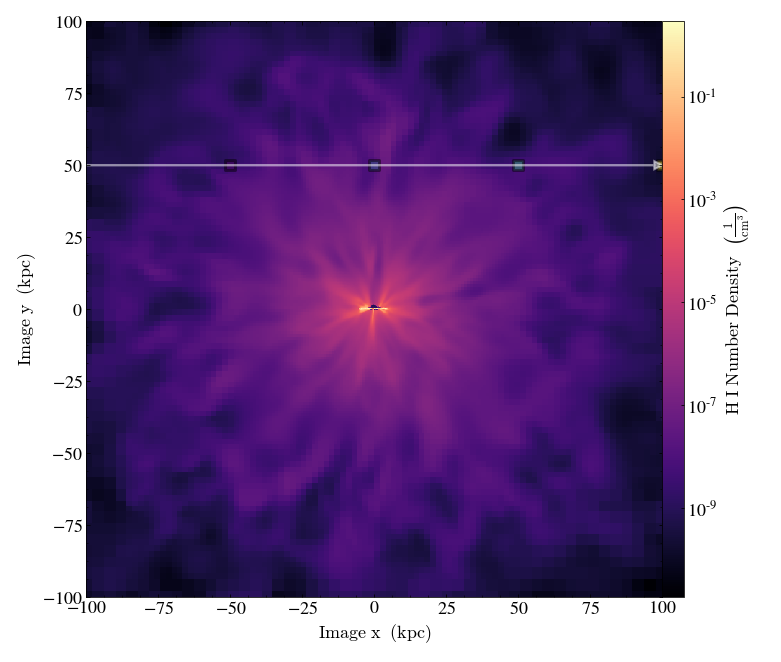

In [62]:
mp.create_slice()

This is then saved and can be interacted with like a regular YT Slice plot


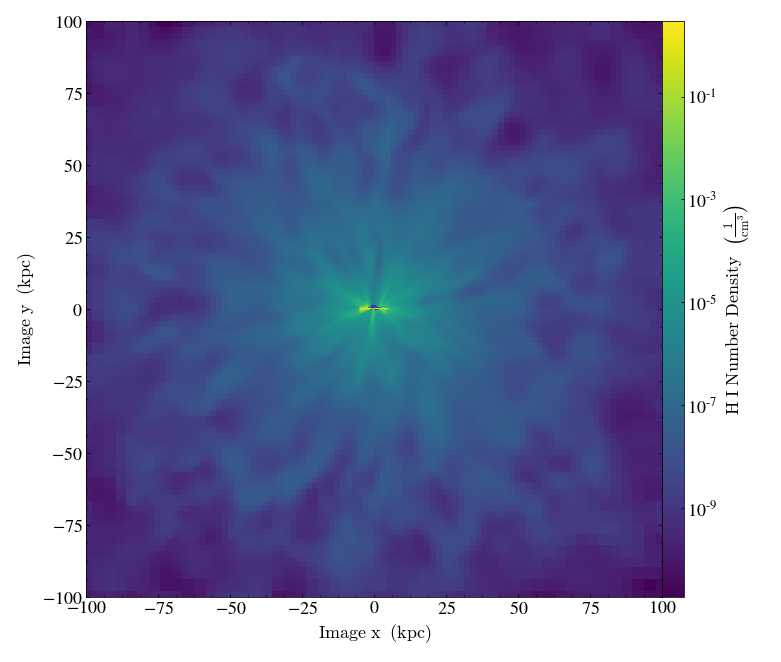

In [63]:
#add a title
mp.slice.annotate_title("A Nice Title")

# change the color map
mp.slice.set_cmap('H_p0_number_density', 'viridis')

# clear all annotations
mp.slice.annotate_clear()

You can re add ray/marker annotaions to the slice by using the mp.add_annotations


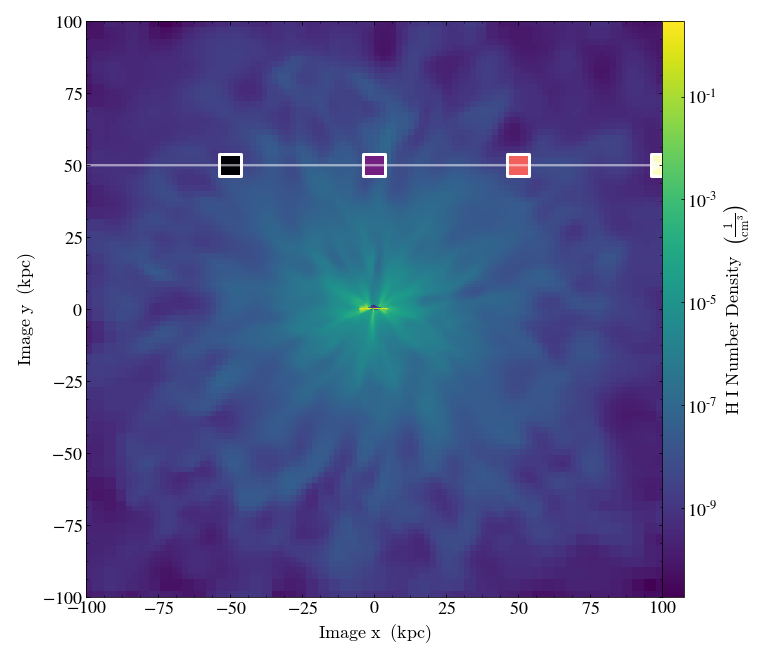

In [64]:
#change some of the marker properties
mp.mark_kwargs
mp.mark_kwargs.update({"s": 500, "edgecolors":'white', "alpha":1})
mp.marker_cmap = "magma"
mp.add_annotations()
mp.slice


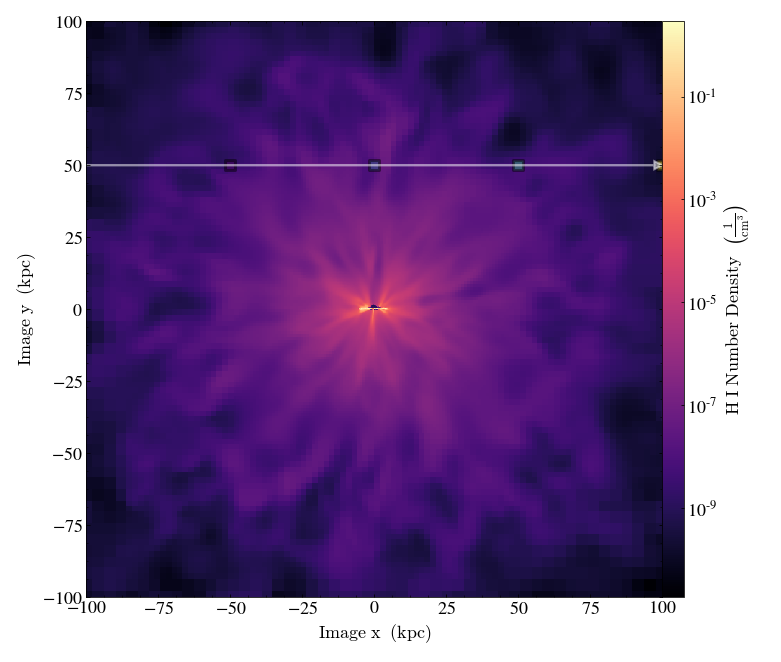

In [65]:
# rest markers and slice back to default
mp.mark_kwargs =  {'alpha' : 0.45,
                   's' : 100,
                   'edgecolors' : 'black',
                   'linewidth' : 3}
mp.marker_cmap = 'viridis'
mp.slice.annotate_clear()
mp.add_annotations()

mp.slice.set_cmap('H_p0_number_density', 'magma')

## Number Density and Line of Sight Velocity Plots
How to make plots of number density and line of sight velocity along light ray

yt : [INFO     ] 2019-08-09 16:55:11,383 Returning an all_data data container.
yt : [INFO     ] 2019-08-09 16:55:11,392 Returning an all_data data container.
yt : [INFO     ] 2019-08-09 16:55:11,401 Returning an all_data data container.


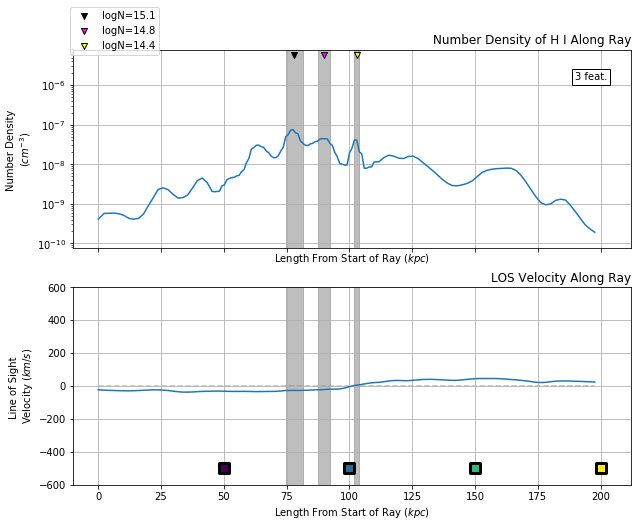

In [66]:
#first create fig and axes
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8), sharex=True)

#plot without the contouring method
mp.contour=False
mp.plot_num_dense_los_vel(ax_num_dense=ax1, ax_los_velocity=ax2)

setting `mp.countour` to true and the class will calculate the absorption features the countour method finds and plot the intervals. It will return the number of features found in the top right. Additionally the largest absorbers (max of 3) will be marked by a triangle and their Log Column Density will be reported

yt : [INFO     ] 2019-08-09 16:55:12,565 Returning an all_data data container.
yt : [INFO     ] 2019-08-09 16:55:12,572 Returning an all_data data container.
yt : [INFO     ] 2019-08-09 16:55:12,580 Returning an all_data data container.


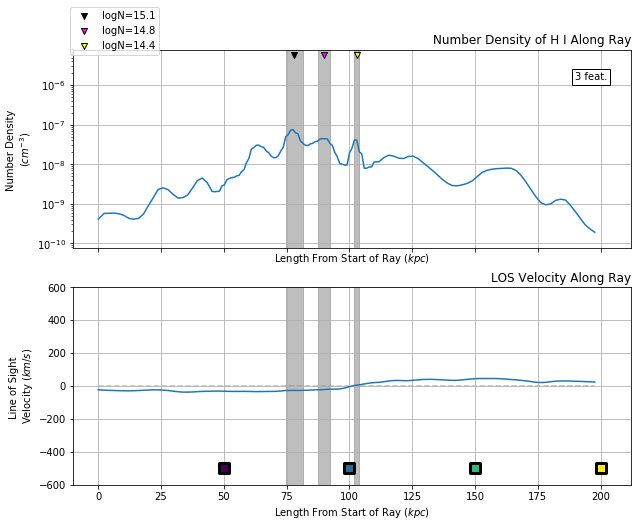

In [67]:
#clear the axes
ax1.clear(); ax2.clear()

#set contour to true and replot everything
mp.contour=True
mp.plot_num_dense_los_vel(ax_num_dense=ax1, ax_los_velocity=ax2)
fig

The axes and figure can now be manipulated like any regular matplotlib figure/axes. In addition to access the pure number density or line of sight velocity you can look at the `"H_p0_number_density"` and `"velocity_los"` fields in `mp.ray`

## Spectra Plots

Absorption spectra plots are made using the trident library and then the plots can be fit, as mentioned before, by using the spectacle library.

Trident can (or will very soon) output the spectra in wavelength space or velocity space. Often velocity space is more useful for comparing with other data and so the multi_plot class defaults to using velocity (though currently wavelength is always made then converted to velocity). 

yt : [INFO     ] 2019-08-09 16:55:14,623 Setting instrument to Custom
yt : [INFO     ] 2019-08-09 16:55:14,644 Creating C_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2019-08-09 16:55:14,655 Creating O_p5_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2019-08-09 16:55:14,666 Creating spectrum
yt : [INFO     ] 2019-08-09 16:55:14,705 134 out of 134 line components will be deposited as unresolved lines.
Adding line - H I 1216 [1215.670100 A]: : 100%|██████████| 134/134 [00:00<00:00, 1855.02it/s]
yt : [INFO     ] 2019-08-09 16:55:14,781 134 out of 134 line components will be deposited as unresolved lines.
Adding line - H I 1026 [1025.722300 A]: : 100%|██████████| 134/134 [00:00<00:00, 2291.48it/s]
yt : [INFO     ] 2019-08-09 16:55:14,845 134 out of 134 line components will be deposited as unresolved lines.
Adding line - H I 973 [972.536800 A]: : 100%|██████████| 134/134 [00:00<00:00, 2507.95it/s]
yt : [INFO     ] 2019-08-0

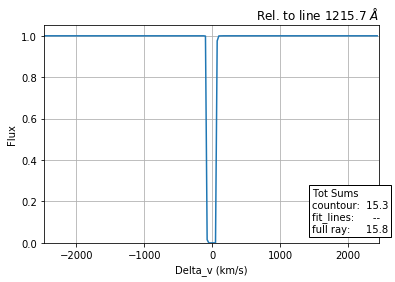

In [68]:
fig, ax = plt.subplots()
mp.use_spectacle=False
wavelength, velocity, flux = mp.plot_spect_vel(ax_vel=ax)

the wavelength, velocity, and flux created by using trident is output for an easy way to look at the spectra with different tools or to plot it in new ways.

We can additionally add more absorption features to the spectra by altering the `mp.ion_list`. and the range/center of the plot can be altered by changing `mp.wavelength_width` and `mp.wavelength_center`

yt : [INFO     ] 2019-08-09 16:55:20,765 Setting instrument to Custom
yt : [INFO     ] 2019-08-09 16:55:20,788 Creating spectrum
yt : [INFO     ] 2019-08-09 16:55:20,822 134 out of 134 line components will be deposited as unresolved lines.
Adding line - H I 1216 [1215.670100 A]: : 100%|██████████| 134/134 [00:00<00:00, 1794.04it/s]
yt : [INFO     ] 2019-08-09 16:55:20,901 134 out of 134 line components will be deposited as unresolved lines.
Adding line - H I 1026 [1025.722300 A]: : 100%|██████████| 134/134 [00:00<00:00, 2412.38it/s]
yt : [INFO     ] 2019-08-09 16:55:20,962 134 out of 134 line components will be deposited as unresolved lines.
Adding line - H I 973 [972.536800 A]: : 100%|██████████| 134/134 [00:00<00:00, 2240.88it/s]
yt : [INFO     ] 2019-08-09 16:55:21,027 134 out of 134 line components will be deposited as unresolved lines.
Adding line - H I 950 [949.743100 A]: : 100%|██████████| 134/134 [00:00<00:00, 2434.71it/s]
yt : [INFO     ] 2019-08-09 16:55:21,090 134 out of 134

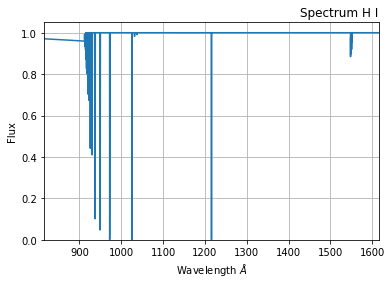

In [69]:
ax.clear()

#append more ions to add to spectra
mp.ion_list.append('C IV')
mp.ion_list.append('O VI')

#increase the width of the window we look at
mp.wavelength_width = 800

#this time look in wavelength space
mp.plot_spect_vel(ax_spect=ax)
fig

There is also an option to look at a single line of the main ion (for example HI 1216). This is especially useful when fitting lines with spectacle and is used internally when fitting with spectacle. The width of this specra is automatically increased so that the tails of the plot go to one, otherwise fitting is near impossible

yt : [INFO     ] 2019-08-09 16:55:27,742 Setting instrument to Custom
yt : [INFO     ] 2019-08-09 16:55:27,749 Creating spectrum
yt : [INFO     ] 2019-08-09 16:55:27,797 134 out of 134 line components will be deposited as unresolved lines.
Adding line - H I 1216 [1215.670100 A]: : 100%|██████████| 134/134 [00:00<00:00, 1657.33it/s]
yt : [INFO     ] 2019-08-09 16:55:27,883 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2019-08-09 16:55:27,888 Returning an all_data data container.
yt : [INFO     ] 2019-08-09 16:55:27,897 Returning an all_data data container.


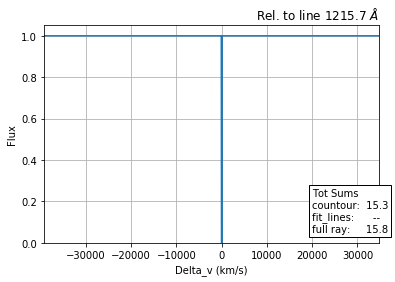

In [70]:
ax.clear()

mp.plot_spect_vel(ax_vel=ax, single_line='H I 1216')
fig

Now lets actually try and use spectacle to fit the lines. Set `mp.use_spectacle` to `True` and the multi_plot class will automatially fit the strongest line of the ion (1216 for HI, 1032 for OVI, etc). If we also set `mp.plot_spectcle` to `True`, multi_plot will plot the strongest lines that it finds (max of 3) on top of the spectra.

yt : [INFO     ] 2019-08-09 16:55:31,033 Setting instrument to Custom
yt : [INFO     ] 2019-08-09 16:55:31,053 Creating spectrum
yt : [INFO     ] 2019-08-09 16:55:31,085 134 out of 134 line components will be deposited as unresolved lines.
Adding line - H I 1216 [1215.670100 A]: : 100%|██████████| 134/134 [00:00<00:00, 1962.23it/s]
yt : [INFO     ] 2019-08-09 16:55:31,159 134 out of 134 line components will be deposited as unresolved lines.
Adding line - H I 1026 [1025.722300 A]: : 100%|██████████| 134/134 [00:00<00:00, 2307.83it/s]
yt : [INFO     ] 2019-08-09 16:55:31,222 134 out of 134 line components will be deposited as unresolved lines.
Adding line - H I 973 [972.536800 A]: : 100%|██████████| 134/134 [00:00<00:00, 2279.41it/s]
yt : [INFO     ] 2019-08-09 16:55:31,285 134 out of 134 line components will be deposited as unresolved lines.
Adding line - H I 950 [949.743100 A]: : 100%|██████████| 134/134 [00:00<00:00, 2389.33it/s]
yt : [INFO     ] 2019-08-09 16:55:31,348 134 out of 134

Adding line - H I 1026 [1025.722300 A]: : 100%|██████████| 134/134 [00:00<00:00, 2112.33it/s]
yt : [INFO     ] 2019-08-09 16:55:33,917 134 out of 134 line components will be deposited as unresolved lines.
Adding line - H I 973 [972.536800 A]: : 100%|██████████| 134/134 [00:00<00:00, 2321.46it/s]
yt : [INFO     ] 2019-08-09 16:55:33,981 134 out of 134 line components will be deposited as unresolved lines.
Adding line - H I 950 [949.743100 A]: : 100%|██████████| 134/134 [00:00<00:00, 2599.24it/s]
yt : [INFO     ] 2019-08-09 16:55:34,038 134 out of 134 line components will be deposited as unresolved lines.
Adding line - H I 938 [937.803500 A]: : 100%|██████████| 134/134 [00:00<00:00, 2499.53it/s]
yt : [INFO     ] 2019-08-09 16:55:34,098 134 out of 134 line components will be deposited as unresolved lines.
Adding line - H I 931 [930.748300 A]: : 100%|██████████| 134/134 [00:00<00:00, 2879.15it/s]
yt : [INFO     ] 2019-08-09 16:55:34,149 134 out of 134 line components will be deposited as u

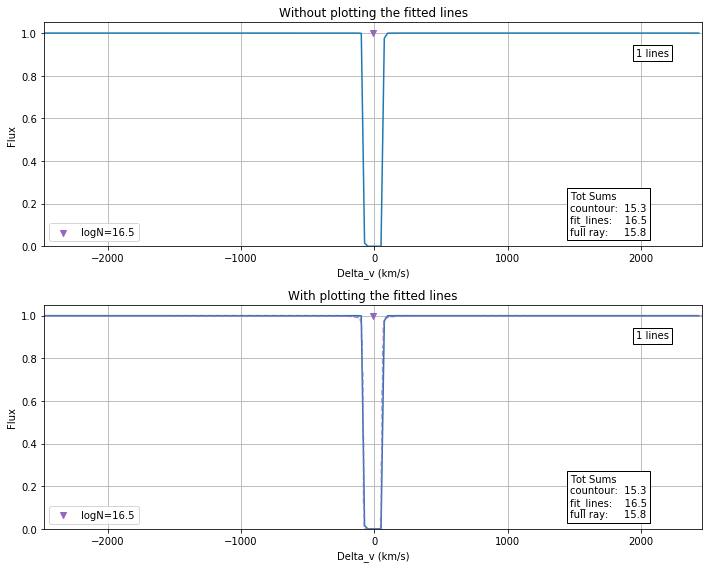

In [71]:
#create new figure
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8))

#remove other ions from list so they won't be plotted
mp.ion_list=['H I']
mp.wavelength_width = 20
#set multiplot to try and fit the lines
mp.use_spectacle=True
mp.plot_spectacle=False
#plot the spectra and replace the default title
mp.plot_spect_vel(ax_vel=ax1)
ax1.set_title("", loc='right')
ax1.set_title("Without plotting the fitted lines")

#now set multi_plot to also plot the fits
mp.plot_spectacle = True

#plot the spectra and replace the default title
mp.plot_spect_vel(ax_vel=ax2)
ax2.set_title("", loc='right')
ax2.set_title("With plotting the fitted lines")

fig.tight_layout()

The above plot has quite a bit going on but each part can be explained. 
* The legend in the bottom left with the triangles is marking the largest lines that spectacle fit and reports their Log column density (with N in cm^-2). 
* The top right is simply reporting the total number of lines that were fit to this spectra. 
* Finally, the bottom right lists the total column density for the ray calculated using the three methods descibed above

## The Whole Shabang

Combining pretty much all these features, we can create the multi_plot that makes it easy to look from the slice of data we're looking at, to the number desnity/line of sight velocity and finally the spectra that holds the only information that observers have. 

There is a lot of information packed in this plot and can be overwhelming at times. Different features can be turned off (like plotting spectacle or the contour method) if there seems to be too much going on.

But to create the multi_plot all you have to do is get your settings the way you want them and then call `mp.create_multi_plot`. it is automatically plotted to mp.fig which is just a matpotlib figure

yt : [INFO     ] 2019-08-09 16:55:53,155 Returning an all_data data container.
yt : [INFO     ] 2019-08-09 16:55:53,164 Returning an all_data data container.
yt : [INFO     ] 2019-08-09 16:55:53,172 Returning an all_data data container.
yt : [INFO     ] 2019-08-09 16:55:53,218 Setting instrument to Custom
yt : [INFO     ] 2019-08-09 16:55:53,234 Creating spectrum
yt : [INFO     ] 2019-08-09 16:55:53,269 134 out of 134 line components will be deposited as unresolved lines.
Adding line - H I 1216 [1215.670100 A]: : 100%|██████████| 134/134 [00:00<00:00, 1982.16it/s]
yt : [INFO     ] 2019-08-09 16:55:53,341 134 out of 134 line components will be deposited as unresolved lines.
Adding line - H I 1026 [1025.722300 A]: : 100%|██████████| 134/134 [00:00<00:00, 2256.04it/s]
yt : [INFO     ] 2019-08-09 16:55:53,405 134 out of 134 line components will be deposited as unresolved lines.
Adding line - H I 973 [972.536800 A]: : 100%|██████████| 134/134 [00:00<00:00, 2468.98it/s]
yt : [INFO     ] 2019


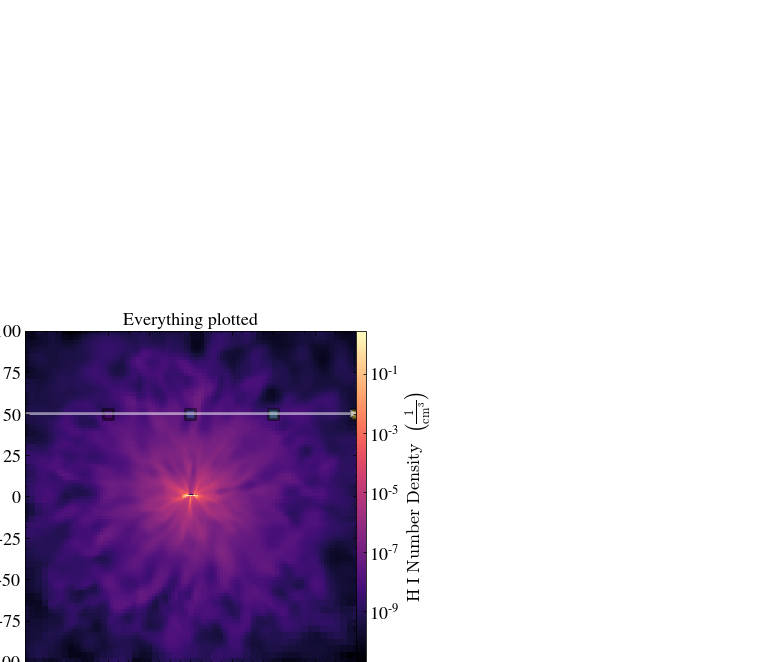

In [73]:
mp.create_multi_plot()
# for some reason if create_slice and create_multi_plot are called in 
# different cells then the slice will appear blank until you interact with it
mp.slice.annotate_title("Everything plotted")

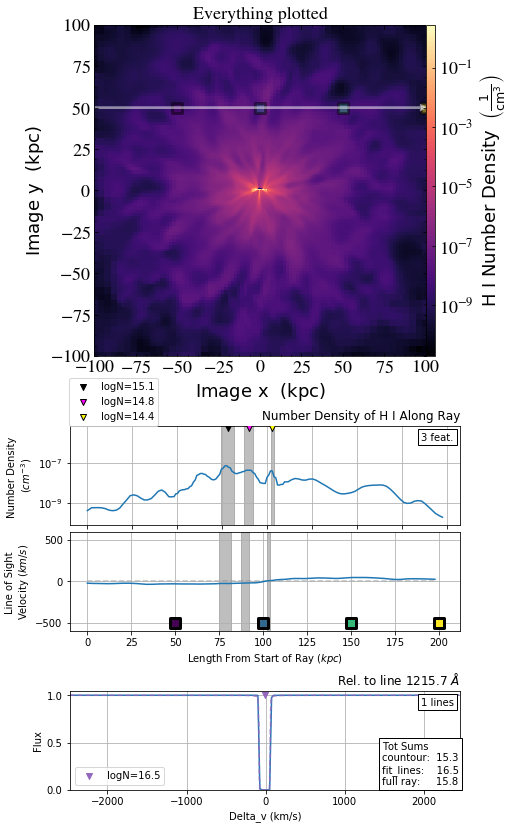

In [74]:
mp.fig

We can turn of some of the features with `mp.plot_contour` and `mp.plot_spectacle`. Also note that `mp.create_multi_plot()` returns the figure and axes that everything was plotted on so you can edit them like a regular matplotlib. (Warning!! the position of the plots are hard coded in so be careful if you mess with that)

yt : [INFO     ] 2019-08-09 16:56:12,298 Returning an all_data data container.
yt : [INFO     ] 2019-08-09 16:56:12,304 Returning an all_data data container.
yt : [INFO     ] 2019-08-09 16:56:12,312 Returning an all_data data container.
yt : [INFO     ] 2019-08-09 16:56:12,334 Setting instrument to Custom
yt : [INFO     ] 2019-08-09 16:56:12,354 Creating spectrum
yt : [INFO     ] 2019-08-09 16:56:12,397 134 out of 134 line components will be deposited as unresolved lines.
Adding line - H I 1216 [1215.670100 A]: : 100%|██████████| 134/134 [00:00<00:00, 1917.32it/s]
yt : [INFO     ] 2019-08-09 16:56:12,472 134 out of 134 line components will be deposited as unresolved lines.
Adding line - H I 1026 [1025.722300 A]: : 100%|██████████| 134/134 [00:00<00:00, 2094.14it/s]
yt : [INFO     ] 2019-08-09 16:56:12,541 134 out of 134 line components will be deposited as unresolved lines.
Adding line - H I 973 [972.536800 A]: : 100%|██████████| 134/134 [00:00<00:00, 2169.99it/s]
yt : [INFO     ] 2019


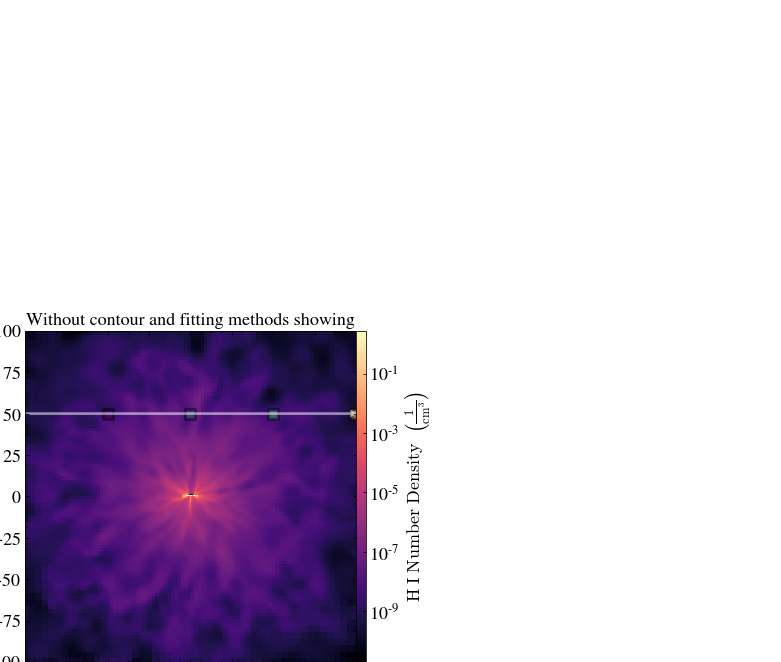

In [75]:
#clear the figure
mp.fig.clear()

#turn over plotting the two methods
mp.plot_contour = False
mp.plot_spectacle = False

fig, (ax1, ax2, ax3) = mp.create_multi_plot()

mp.slice.annotate_clear()
mp.add_annotations()
mp.slice.annotate_title("Without contour and fitting methods showing")

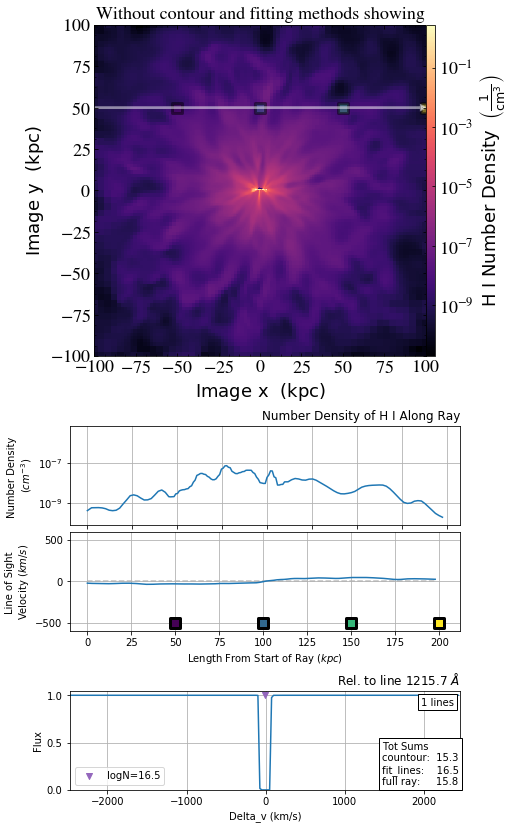

In [76]:
mp.fig